This notebook closely follows the tutorial provided by the PyCWT 0.3.0a22 documentation (https://pycwt.readthedocs.io/en/latest/index.html). <br>
PyCWT authors include Sebastian Krieger, Nabil Freij, Alexey Brazhe, Christopher Torrence, Gilbert P. Compo, and contributors. <br>
PyCWT code is based on Torrence and Compo (1998) (https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2).

In [2]:
from __future__ import division #-- changes the / operator to mean true division throughout the notebook

import numpy as np
import xarray as xr
import pycwt as wavelet
import matplotlib.pyplot as plt

### Analysis

Select timeseries data

In [5]:
#-- Options:
#-- varName = 'nino34'

ts_data = get_data(varName='nino34')

Create a time array in years

In [26]:
dt = 1/12
N = len(ts_data)
yearStart = 1500

yearRange = create_timeArray(yearStart, dt, N)

Detrend input data by fitting a one-degree polynomial function and subtract from the original data

In [13]:
ts_data_noTrend = detrend_data(ts_data, yearRange, yearStart)

Normalize detrended data by its standard deviation

In [16]:
ts_norm, std, variance = normalize_data(ts_data_noTrend)

Define parameters of the wavelet analysis

In [22]:
waveNumber = 6

mother = wavelet.Morlet(waveNumber)  ;#-- Morlet wavelet
s0 = 2 * dt                          ;#-- Starting scale, e.g. 2*(1/12) years = 2 months
dj = 1/12                            ;#-- Twelve sub-octaves per octave
J = 7/dj                             ;#-- Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(ts_data)   ;#-- Lag-1 autocorrelation for red noise

Perform wavelet transform and inverse wavelet transform (inverse transform multiplied by the standard deviation of detrended input data since this data was normalized)

In [23]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(ts_norm, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

Calculate the normalized wavelet, Fourier power spectra, and Fourier equivalent periods for each wavelet scale (power spectrum is corrected according to Liu et al. (2007) https://doi.org/10.1175/2007JTECHO511.1)

In [25]:
power, fft_power, period = calculate_power(wave, freqs, scales)

Perform power spectra significance test

In [28]:
sig95, fft_theor = calculate_power_significance(power, dt, N, scales, alpha, sig_level=0.95)

Calculate global wavelet spectrum and its significance level

In [30]:
global_power, global_sig, tmp = calculate_global_power(power, dt, N, scales, alpha, variance, sig_level=0.95)

Calculate the scale average for a range of years and its significance level

In [36]:
scale_ave_range = [2,8]

scale_ave, scale_ave_sig = calculate_scale_average(power, dt, N, scales, alpha, variance, dj, tmp,
                                                   scale_ave_range, sig_level=0.95)

### Plot

Four different subplots containing the (a) original series anomaly and the inverse wavelet transform; (b) the wavelet power spectrum (c) the global wavelet and Fourier spectra ; and (d) the range averaged wavelet spectrum. In all sub-plots the significance levels are either included as dotted lines or as filled contour lines

/home/bla390/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


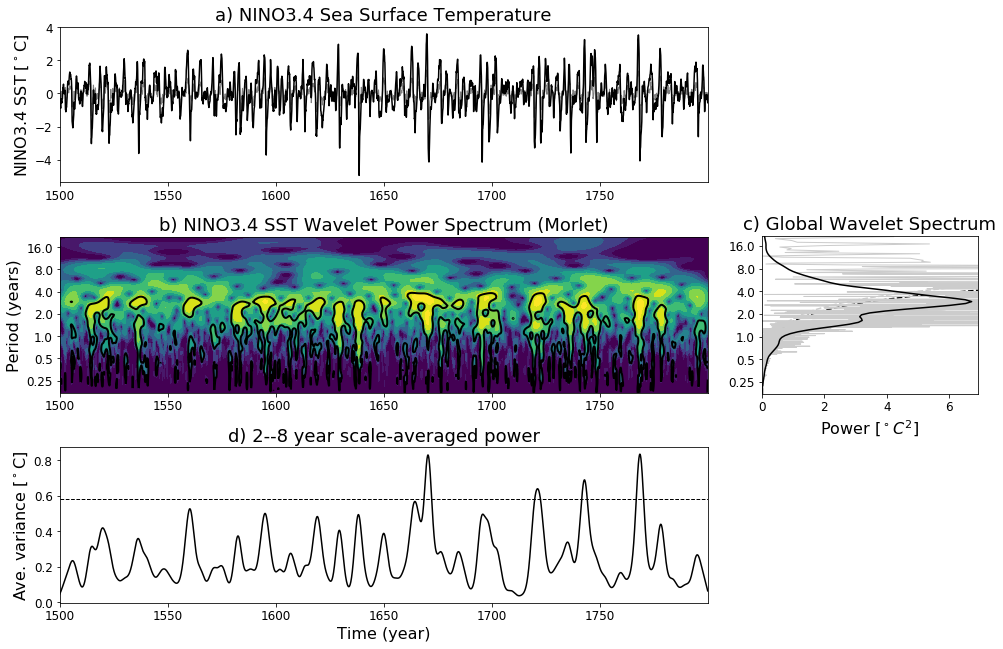

In [38]:
fig1 = plt.figure(figsize=(15, 10))

gs1 = plt.GridSpec(3, 1)
gs1.update(left=0.10, right=0.70, bottom = 0.10, top = 0.90, wspace=0.00, hspace = 0.35)
gs2 = plt.GridSpec(1,1)
gs2.update(left=0.75, right=0.95, bottom = 0.39, top = 0.61, wspace=0.00, hspace = 0.00)

#=======================================================================================

#-- Original time series anomaly, inverse wavelet transform
ax1 = plt.subplot(gs1[0, 0])
ax1.plot(yearRange, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax1.plot(yearRange, ts_data, 'k', linewidth=1.5)
ax1.set_title('a) NINO3.4 Sea Surface Temperature', fontsize=18)
ax1.set_ylabel('NINO3.4 SST [$^\circ$C]', fontsize=16)
ax1.set_xlim([yearRange.min(), yearRange.max()])
ax1.tick_params(axis='both', labelsize=12)

#-- Normalized wavelet power spectrum, significance level contour lines
ax2 = plt.subplot(gs1[1, 0])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
ax2.contourf(yearRange, np.log2(period), np.log2(power), np.log2(levels), 
             extend='both', cmap=plt.cm.viridis)
extent = [yearRange.min(), yearRange.max(), 0, max(period)]
ax2.contour(yearRange, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2, extent=extent)
ax2.set_title('b) NINO3.4 SST Wavelet Power Spectrum (Morlet)', fontsize=18)
ax2.set_ylabel('Period (years)', fontsize=16)

y_ticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
ax2.set_yticks(np.log2(y_ticks))
ax2.set_yticklabels(y_ticks)
ax2.tick_params(axis='both', labelsize=12)

#-- Scale averaged wavelet spectrum
ax3 = plt.subplot(gs1[2, 0])
ax3.axhline(scale_ave_sig, color='k', linestyle='--', linewidth=1.)
ax3.plot(yearRange, scale_ave, 'k-', linewidth=1.5)
ax3.set_title('d) {}--{} year scale-averaged power'.format(scale_ave_range[0], scale_ave_range[1]), fontsize=18)
ax3.set_xlabel('Time (year)', fontsize=16)
ax3.set_ylabel('Ave. variance [$^\circ$C]', fontsize=16)
ax3.set_xlim([yearRange.min(), yearRange.max()])
ax3.tick_params(axis='both', labelsize=12)
              
#-- Global wavelet spectra, Fourier power spectra, theoretical noise spectra
ax4 = plt.subplot(gs2[0, 0])
ax4.plot(global_sig, np.log2(period), 'k--')
ax4.plot(variance * fft_theor, np.log2(period), '--', color='#cccccc')
ax4.plot(variance * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc', linewidth=1.)
ax4.plot(variance * global_power, np.log2(period), 'k-', linewidth=1.5)
ax4.set_title('c) Global Wavelet Spectrum', fontsize=18)
ax4.set_xlabel('Power [$^\circ$$C^2$]', fontsize=16)
ax4.set_xlim([0, global_power.max() + variance])
ax4.set_ylim(np.log2([period.min(), period.max()]))
ax4.set_yticks(np.log2(y_ticks))
ax4.set_yticklabels(y_ticks)
ax4.tick_params(axis='both', labelsize=12)

#=======================================================================================

#path = '/home/bla390/control_run/images/'
#filename = 'control_6_no_convect.nino34.wavelet_power_spectrum.2-8years.png'
#plt.savefig(path+filename)

### Notebook functions

In [4]:
def get_data(varName):
    
    path = r'/home/bla390/control_run/data/diagnostics/'
    filename = 'control_6_no_convect.' + varName + '.1500_1799.monthly.nc'
    ts_data = eval('xr.open_dataset(path+filename).' + varName + '.values')
    
    return ts_data

In [7]:
def create_timeArray(yearStart, dt, N):
    
    yearRange = np.arange(0, N) * dt + yearStart
    
    return yearRange

In [12]:
def detrend_data(ts_data, yearRange, yearStart):

    p = np.polyfit(yearRange - yearStart, ts_data, 1)
    ts_data_noTrend = ts_data - np.polyval(p, yearRange - yearStart)
    
    return ts_data_noTrend

In [15]:
def normalize_data(ts_data_noTrend):

    std = ts_data_noTrend.std()
    variance = std ** 2
    ts_norm = ts_data_noTrend / std
    
    return ts_norm, std, variance

In [24]:
def calculate_power(wave, freqs, scales):

    power = (np.abs(wave)) ** 2
    power /= scales[:, None]
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs

    return power, fft_power, period

In [27]:
def calculate_power_significance(power, dt, N, scales, alpha, sig_level):

    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=sig_level,
                                             wavelet=mother)
    sig95 = np.ones([1, N]) * signif[:, None]
    sig95 = power / sig95
    
    return sig95, fft_theor

In [29]:
def calculate_global_power(power, dt, N, scales, alpha, variance, sig_level):

    global_power = power.mean(axis=1)
    dof = N - scales   ;#-- Correction for padding at edges
    global_signif, tmp = wavelet.significance(variance, dt, scales, 1, alpha,
                                              significance_level=sig_level, dof=dof,
                                              wavelet=mother)

    return global_power, global_signif, tmp

In [35]:
def calculate_scale_average(power, dt, N, scales, alpha, variance, dj, tmp,
                            scale_ave_range, sig_level):

    sel = wavelet.helpers.find((period >= scale_ave_range[0]) & (period < scale_ave_range[1]))
    Cdelta = mother.cdelta
    scale_ave = (scales * np.ones((N, 1))).transpose()
    scale_ave = power / scale_ave   ;#-- As in Torrence and Compo (1998), Eqn. 24 
                                    ;#-- https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2

    scale_ave = variance * dj * dt / Cdelta * scale_ave[sel, :].sum(axis=0)
    scale_ave_sig, tmp = wavelet.significance(variance, dt, scales, 2, alpha,
                                                 significance_level=sig_level,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)
    
    return scale_ave, scale_ave_sig